In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix,  precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout,Input
from tensorflow.keras.preprocessing import image
from sklearn.utils import shuffle
import itertools
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2


import warnings
import cv2
import PIL
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from tensorflow.keras.layers import Dense, Input, ZeroPadding2D, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.activations import relu, softmax
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

In [2]:
# train_dir = r'/content/drive/MyDrive/Srija_Dissertation_2024/Brain_tumor_dataset/Training/'
# test_dir= r'/content/drive/MyDrive/Srija_Dissertation_2024/Brain_tumor_dataset/Testing/'
# ###Uncomment this last two codes if using google colab

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
train_dir = r'/Users/srijakarmakar/Documents/Brain_tumor/Brain_tumor_dataset/Training/'
test_dir= r'/Users/srijakarmakar/Documents/Brain_tumor/Brain_tumor_dataset/Testing/'

In [6]:
def count_image_per_class(directory):
    class_counts={}
    for class_name in os.listdir(directory):
        class_dir=os.path.join(directory,class_name)
        if os.path.isdir(class_dir):
            images_count=len(os.listdir(class_dir))
            class_counts[class_name]=images_count
    return class_counts


In [7]:
##count images per class in training set
train_class_counts=count_image_per_class(train_dir)
##count images per class in test set
test_class_counts=count_image_per_class(test_dir)

In [8]:
train_class_counts

{'pituitary': 1457, 'notumor': 1595, 'glioma': 1321, 'meningioma': 1339}

In [9]:
test_class_counts

{'pituitary': 300, 'notumor': 405, 'glioma': 300, 'meningioma': 306}

In [10]:
classes=list(train_class_counts.keys())
print(f"Number of classes {classes}")
train_counts=list(train_class_counts.values())
test_counts=list(test_class_counts.values())
print(f"Number of training images in each classes {train_counts}")
print(f"Number of Testing images in each classes {test_counts}")

Number of classes ['pituitary', 'notumor', 'glioma', 'meningioma']
Number of training images in each classes [1457, 1595, 1321, 1339]
Number of Testing images in each classes [300, 405, 300, 306]


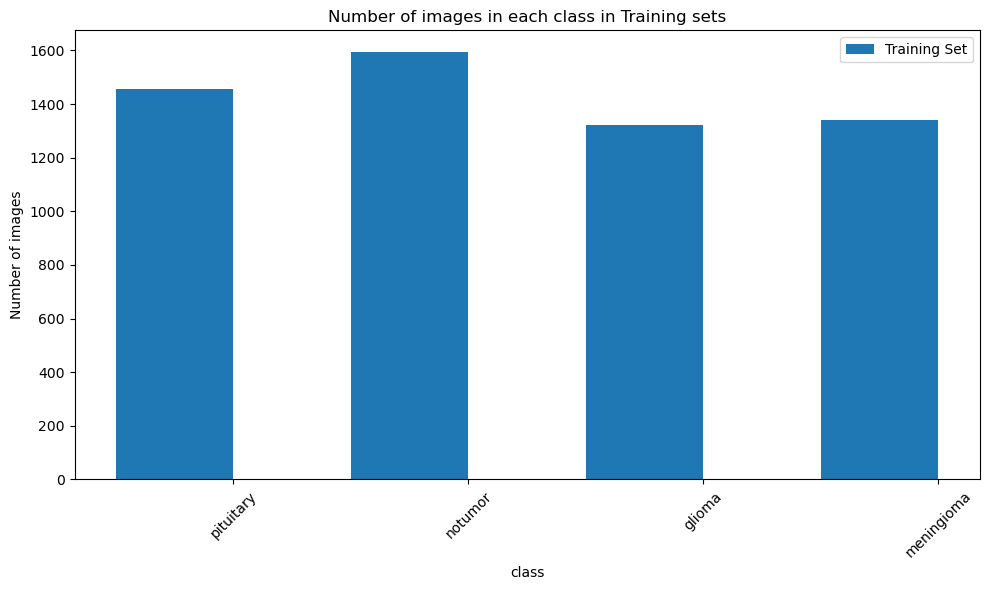

In [11]:
##--plotting--##
plt.figure(figsize=(10,6))
bar_width=0.5
index=range(len(classes))
plt.bar(index,train_counts,bar_width,label="Training Set")
plt.xlabel('class')
plt.ylabel('Number of images')
plt.title("Number of images in each class in Training sets")
plt.xticks([i+bar_width/2 for i in index],classes,rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

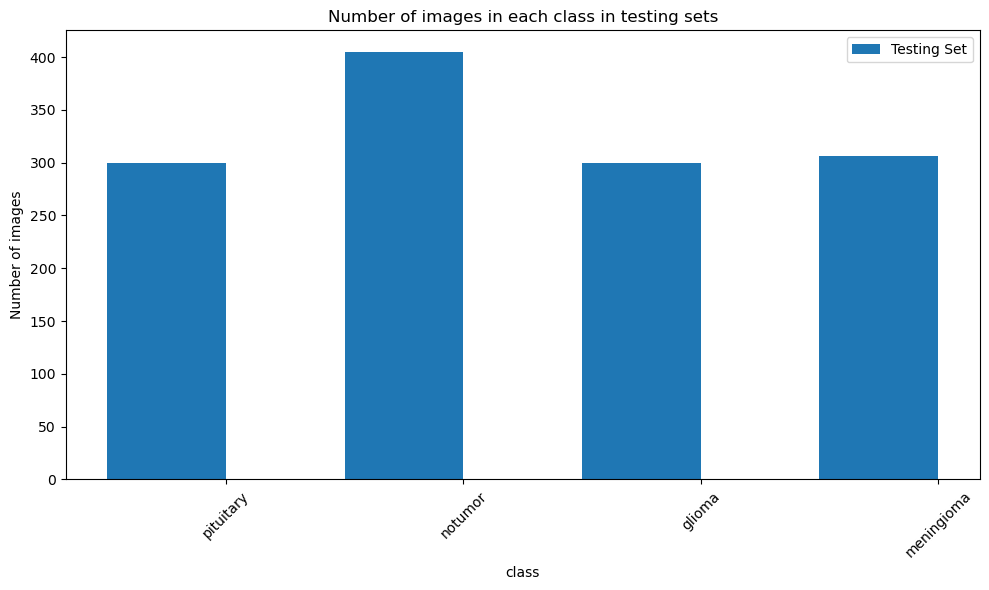

In [12]:
##--plotting--##
plt.figure(figsize=(10,6))
bar_width=0.5
index=range(len(classes))
plt.bar(index,test_counts,bar_width,label="Testing Set")
plt.xlabel('class')
plt.ylabel('Number of images')
plt.title("Number of images in each class in testing sets")
plt.xticks([i+bar_width/2 for i in index],classes,rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
train_dataset = image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=30
)

val_dataset = image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=30
)

test_dataset = image_dataset_from_directory(
    directory=test_dir,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=(150, 150),
    shuffle=False
)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [14]:
classes = train_dataset.class_names
print(classes)

# Create reverse mapping of classes
reverse_classes = {val: key for key, val in enumerate(classes)}
print(reverse_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [27]:
reverse_classes.values()

dict_values([0, 1, 2, 3])

In [15]:
train_iterator = iter(train_dataset)
x_batch, y_batch = next(train_iterator)
print(x_batch.shape, y_batch.shape)


(32, 150, 150, 3) (32,)


2024-06-20 12:20:11.217680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4570]
	 [[{{node Placeholder/_4}}]]
2024-06-20 12:20:11.217823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4570]
	 [[{{node Placeholder/_0}}]]
2024-06-20 12:20:11.244200: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2024-06-20 12:20:11.348261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4570]
	 [[{{node Placeholder/_0}}]]
2024-06-20 12:20:11.348400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4570]
	 [[{{node Placeholder/_4}}]]


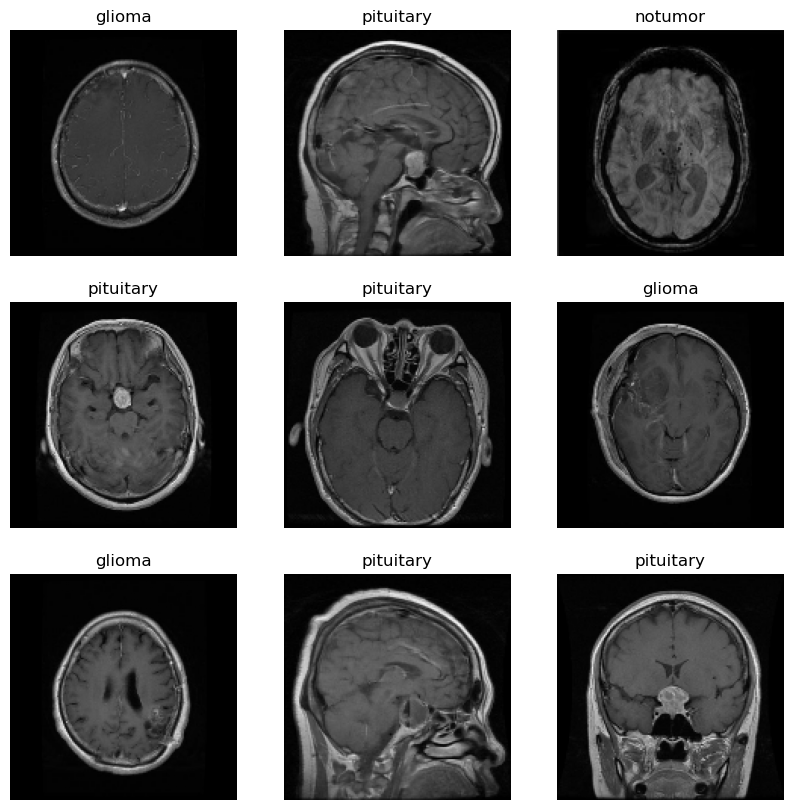

In [16]:
plt.figure(figsize = (10, 10))

for images, label in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255)
        plt.title(train_dataset.class_names[label[i]])
        plt.axis("off")
        
        


In [31]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

train_labels = []

# Iterate through the train_dataset to extract labels
for images, labels in train_dataset:
    train_labels.extend(labels.numpy())

# Convert train_labels to numpy array
train_labels = np.array(train_labels)

In [33]:
np.unique(train_labels)

array([0, 1, 2, 3], dtype=int32)

In [43]:
class_weights=compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)

In [44]:
class_weights

array([1.09539789, 1.0717636 , 0.88087895, 0.98152921])

In [45]:
class_weights_dict = dict(zip(np.unique(train_labels), class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.0953978906999042, 1: 1.0717636022514072, 2: 0.8808789514263685, 3: 0.9815292096219931}


In [46]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_dataset = train_dataset.cache().prefetch(buffer_size = AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size = AUTOTUNE)


In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((150, 150, 3)),
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),  # Additional dense layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer after the additional dense layer
    tf.keras.layers.Dense(4, activation='softmax')  # Output layer with softmax activation for multi-class classification
])






In [50]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [52]:
# history = model.fit(train_dataset, validation_data = val_dataset, epochs = 10)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, class_weight=class_weights_dict)

Epoch 1/10


2024-06-20 12:38:20.501983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype double and shape [4]
	 [[{{node Placeholder/_17}}]]
2024-06-20 12:38:20.502271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype double and shape [4]
	 [[{{node Placeholder/_17}}]]


143/143 [==============================] - ETA: 0s - loss: 1.2065 - accuracy: 0.4449

2024-06-20 12:39:00.855321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1142]
	 [[{{node Placeholder/_4}}]]
2024-06-20 12:39:00.855462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1142]
	 [[{{node Placeholder/_0}}]]


143/143 [==============================] - 44s 303ms/step - loss: 1.2065 - accuracy: 0.4449 - val_loss: 0.8878 - val_accuracy: 0.7417
Epoch 2/10
143/143 [==============================] - 46s 320ms/step - loss: 0.9412 - accuracy: 0.6153 - val_loss: 0.6622 - val_accuracy: 0.7802
Epoch 3/10
143/143 [==============================] - 47s 324ms/step - loss: 0.7729 - accuracy: 0.6963 - val_loss: 0.5463 - val_accuracy: 0.7881
Epoch 4/10
143/143 [==============================] - 47s 328ms/step - loss: 0.7102 - accuracy: 0.7324 - val_loss: 0.5162 - val_accuracy: 0.8301
Epoch 5/10
143/143 [==============================] - 47s 330ms/step - loss: 0.6466 - accuracy: 0.7589 - val_loss: 0.4766 - val_accuracy: 0.8389
Epoch 6/10
143/143 [==============================] - 48s 337ms/step - loss: 0.5965 - accuracy: 0.7803 - val_loss: 0.4347 - val_accuracy: 0.8415
Epoch 7/10
143/143 [==============================] - 53s 369ms/step - loss: 0.5455 - accuracy: 0.8013 - val_loss: 0.4034 - val_accuracy: 0.8

In [53]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/41 [..............................] - ETA: 5s - loss: 0.7934 - accuracy: 0.5625

2024-06-20 12:47:26.399581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1311]
	 [[{{node Placeholder/_4}}]]
2024-06-20 12:47:26.399809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1311]
	 [[{{node Placeholder/_4}}]]


41/41 [==============================] - 4s 86ms/step - loss: 0.4432 - accuracy: 0.8345
Test Loss: 0.44315239787101746
Test Accuracy: 0.8344774842262268


41/41 [==============================] - 4s 84ms/step


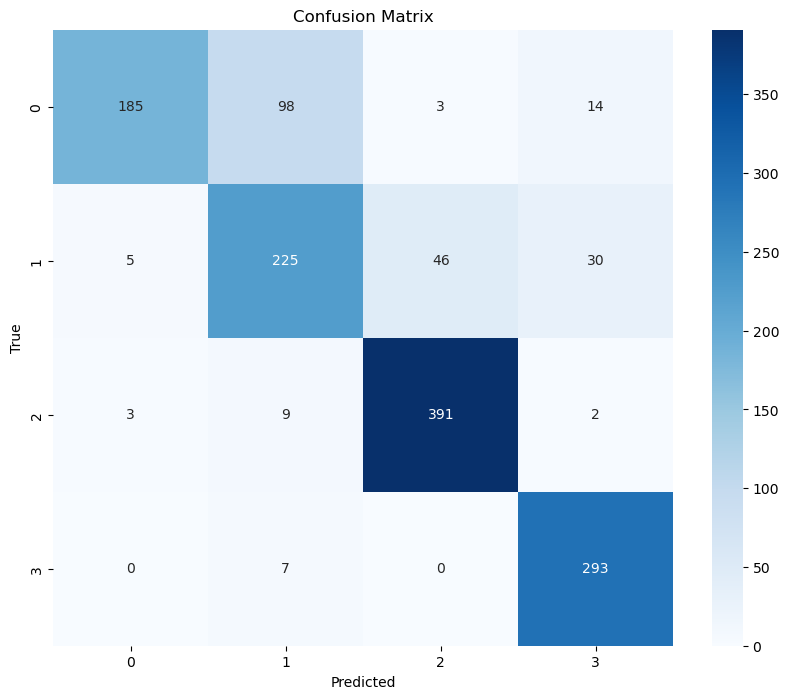

Class: 0
Precision: 0.9585492227979274
Recall: 0.6166666666666667
F1-score: 0.7505070993914807
-----------------------------
Class: 1
Precision: 0.6637168141592921
Recall: 0.7352941176470589
F1-score: 0.6976744186046513
-----------------------------
Class: 2
Precision: 0.8886363636363637
Recall: 0.9654320987654321
F1-score: 0.9254437869822485
-----------------------------
Class: 3
Precision: 0.8643067846607669
Recall: 0.9766666666666667
F1-score: 0.9170579029733958
-----------------------------
Macro-averaged Precision: 0.8438022963135875
Macro-averaged Recall: 0.8235148874364561
Macro-averaged F1-score: 0.8226708019879442


In [54]:
# Get the true class labels from the test_dataset
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())

# Convert the true class labels to numpy array
y_true = np.array(y_true)

# Get the predicted class labels using the model
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=reverse_classes.values(), yticklabels=reverse_classes.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Compute precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average=None)
recall = recall_score(y_true, y_pred_classes, average=None)
f1 = f1_score(y_true, y_pred_classes, average=None)

for i, class_name in enumerate(reverse_classes.values()):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-score: {f1[i]}")
    print("-----------------------------")

# Compute macro-averaged precision, recall, and F1-score
macro_precision = precision_score(y_true, y_pred_classes, average='macro')
macro_recall = recall_score(y_true, y_pred_classes, average='macro')
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Macro-averaged Precision: {macro_precision}")
print(f"Macro-averaged Recall: {macro_recall}")
print(f"Macro-averaged F1-score: {macro_f1}")


In [55]:
# Get the class names from reverse_classes dictionary
class_names = list(reverse_classes.keys())

# Build the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Print the classification report
print(report)


              precision    recall  f1-score   support

      glioma       0.96      0.62      0.75       300
  meningioma       0.66      0.74      0.70       306
     notumor       0.89      0.97      0.93       405
   pituitary       0.86      0.98      0.92       300

    accuracy                           0.83      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.85      0.83      0.83      1311



In [56]:
y_true

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [57]:
y_pred_classes

array([1, 3, 0, ..., 3, 3, 3])

In [58]:
df = pd.DataFrame({'True': y_true, 'Predicted': y_pred_classes})

df

,True,Predicted
0,0,1
1,0,3
2,0,0
3,0,1
4,0,0
...,...,...
1306,3,3
1307,3,3
1308,3,3
1309,3,3


In [59]:
# pip install pydot graphviz

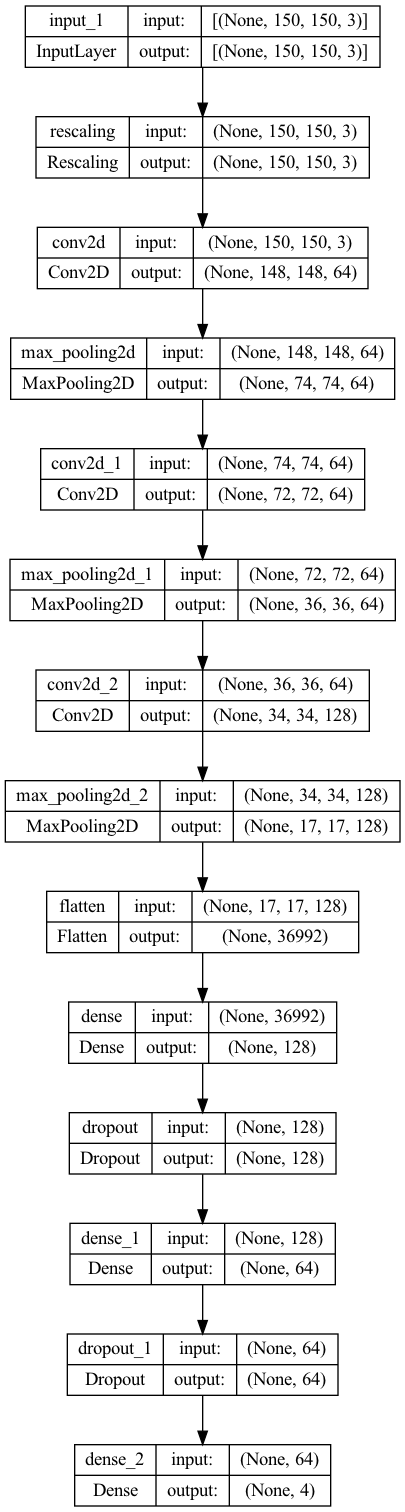

In [60]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

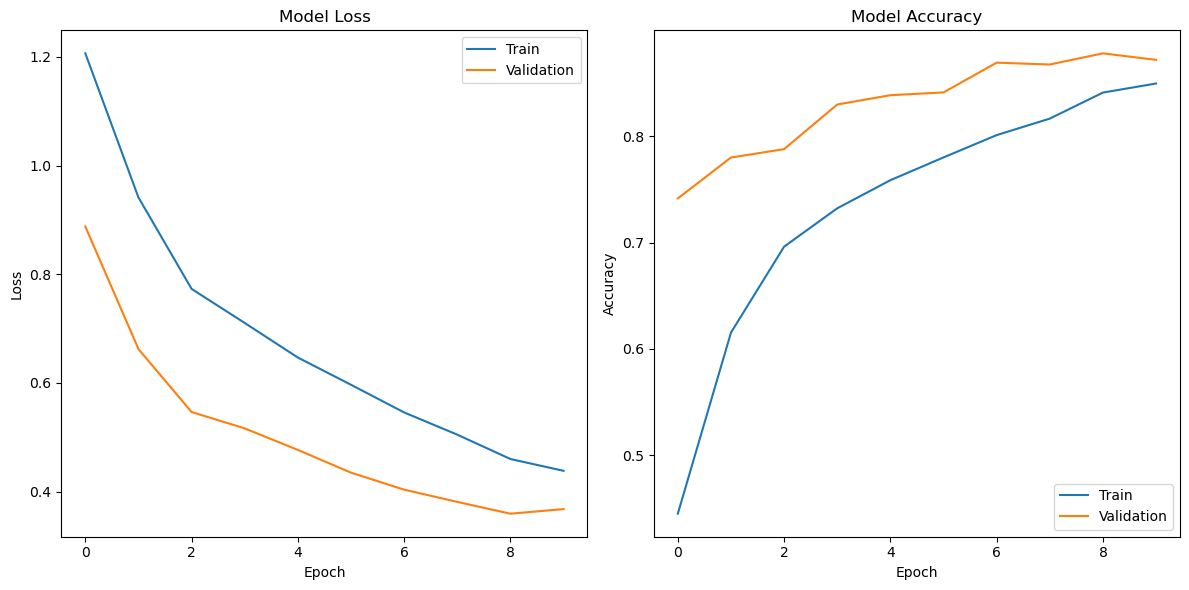

In [61]:
# Plot training and validation curves
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()
